In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.stattools import grangercausalitytests, coint

## Problem 1

**Read in the series 'A.csv', 'B.csv', 'C.csv'**

In [2]:
a_df = pd.read_csv('A.csv',header=0, index_col=0, names=['A'])
b_df = pd.read_csv('B.csv', header=0, index_col=0, names=['B'])
c_df = pd.read_csv('C.csv', header=0, index_col=0, names=['C'])

seriesABC = pd.concat([a_df, b_df, c_df], axis=1)
seriesABC.head()

,A,B,C
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,-1.690123,-0.809757,0.420383
3,-1.219096,-0.412396,-2.200924
4,-1.410304,-2.072510,-1.201323


**Plot the data and observe**

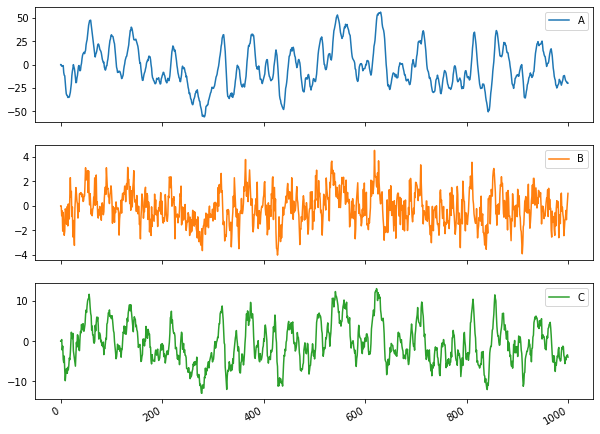

In [3]:
seriesABC.plot(subplots=True, figsize=(10,8))
plt.show()

**Create a VAR model**

In [4]:
model = VAR(seriesABC)

**Determine optimum lag order (p) by Lag order selection**

In [5]:
lag_order = model.select_order(15)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        8.543       8.558       5131.       8.549
1       0.2952      0.3548       1.343      0.3179
2     0.02932*     0.1336*      1.030*    0.06900*
3      0.03951      0.1885       1.040     0.09619
4      0.04831      0.2420       1.049      0.1220
5      0.05904      0.2975       1.061      0.1497
6      0.07068      0.3538       1.073      0.1784
7      0.08682      0.4147       1.091      0.2115
8      0.09559      0.4681       1.100      0.2373
9      0.09996      0.5172       1.105      0.2587
10      0.1029      0.5649       1.108      0.2786
11      0.1147      0.6213       1.122      0.3074
12      0.1244      0.6758       1.133      0.3342
13      0.1273      0.7234       1.136      0.3540
14      0.1357      0.7765       1.146      0.3794
15      0.1421      0.8276       1.153      0.4028
-------------------------------

**Model fit at optimum lag order and get results**

In [6]:
results = model.fit(2)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, May, 2022
Time:                     23:20:05
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.150727
Nobs:                     998.000    HQIC:                 0.0867368
Log likelihood:          -4251.00    FPE:                    1.04865
AIC:                    0.0474994    Det(Omega_mle):         1.02689
--------------------------------------------------------------------
Results for equation A
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.021805         0.032702           -0.667           0.505
L1.A          0.506941         0.029924           16.941           0.000
L1.B          0.019381         0.032257            0.601           0.548
L1.C          1.036461 

**Use results to find roots (number of roots = K*p)**

In [7]:
nroots = 3*2  # K*p (K is number of features = 3, p is lag order = 2)
print('Roots =')
for i in range(0, nroots):
    print(VARResults.roots(results)[i])
print()
print('Moduli =')
for i in range(0, nroots):
    print(np.absolute(VARResults.roots(results)[i]))

Roots =
(-5.038356099006585-0j)
(-2.7597975398912267+0.9514553898601926j)
(-2.7597975398912267-0.9514553898601926j)
(1.29510203359811+0.2445593762766861j)
(1.29510203359811-0.2445593762766861j)
(1.144089199970434-0j)

Moduli =
5.038356099006585
2.919203627718299
2.919203627718299
1.3179903512373685
1.3179903512373685
1.144089199970434


**Is the model stationary?**

Yes, the model is stationary since all the roots moduli are greater than 1

**Is the model cointegrated?**

Since, the model is stationary (all root moduli are greater than 1), therefore the model is not cointegrated

**If Stationary:**

**Investigate Granger causality between series combinations (if any)**

In [8]:
fitted_df = pd.DataFrame(VARResults.fittedvalues(results), columns=['A', 'B', 'C'])
cols = fitted_df.columns

df = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
for i in df.columns:
    for j in df.index:
        result = grangercausalitytests(fitted_df[[i, j]], maxlag=5, verbose=False)
        p_values = [round(result[i+1][0]['ssr_chi2test'][1], 4) for i in range(5)]
        min_p_value = np.min(p_values)
        df.loc[i, j] = min_p_value

df

,A,B,C
A,1.0000,0.0,0.0000
B,0.0082,1.0,0.0041
C,0.0000,0.0,1.0000


**Use IRF plots to confirm your causality conclusions**

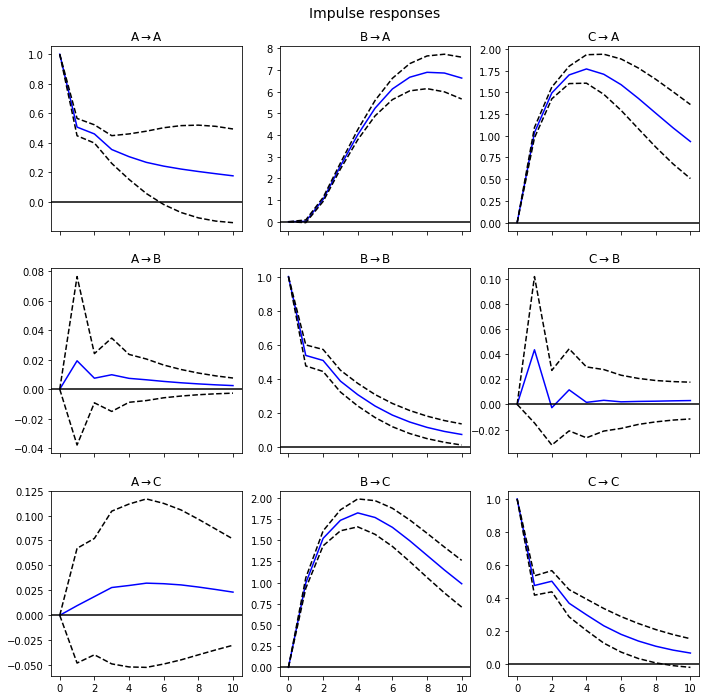

In [10]:
irf = results.irf(10)
irf.plot(orth=False)
plt.show()

**Order the variables in decreasing order of exogenity**

After investigating the values from granger casuality and confirming it from the IRF results. We get C->A, B->A, B->C.

Hence, the decreasing order of exogenity is B,C,A

**Whether VAR or VECM model, perform a dynamic forecast 10 steps forward and plot**

Forecasted values:
[[-16.73198691  -0.0275754   -1.74524227]
 [-14.87388923  -0.05062249  -1.17957538]
 [-12.84811565  -0.0717821   -0.94006082]
 [-10.9453644   -0.09968511  -0.7323798 ]
 [ -9.26022683  -0.11510619  -0.62084044]
 [ -7.82351951  -0.12965267  -0.55400051]
 [ -6.64701559  -0.13902214  -0.52269445]
 [ -5.70840005  -0.14579466  -0.51265473]
 [ -4.97966591  -0.15000645  -0.51508256]
 [ -4.42635623  -0.15244972  -0.52394448]]


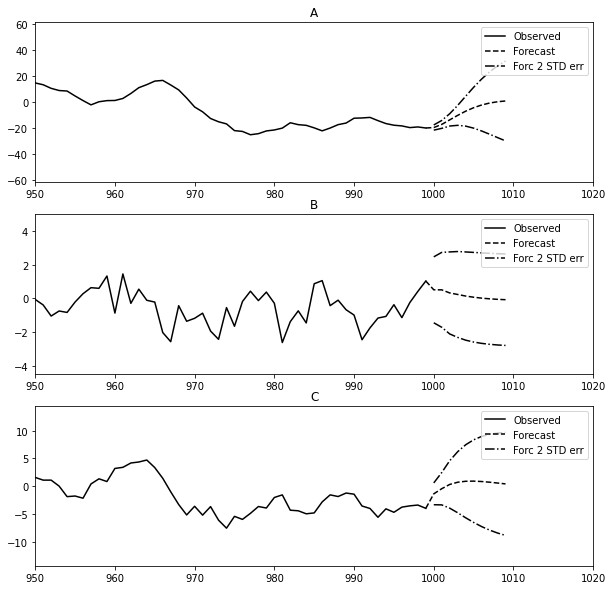

In [25]:
forecast_values = results.forecast(fitted_df.values[-2:], 10)
print('Forecasted values:')
print(forecast_values)

results.plot_forecast(10)
plt1 = plt.subplot(311)
plt1.set_xlim(950, 1020)
plt2 = plt.subplot(312)
plt2.set_xlim(950, 1020)
plt3 = plt.subplot(313)
plt3.set_xlim(950, 1020)
plt.show()

## Problem 2

**Read in the series 'X.csv', 'Y.csv', 'Z.csv'**

In [26]:
x_df = pd.read_csv('X.csv',header=0, index_col=0, names=['X'])
y_df = pd.read_csv('Y.csv', header=0, index_col=0, names=['Y'])
z_df = pd.read_csv('Z.csv', header=0, index_col=0, names=['Z'])

seriesXYZ = pd.concat([x_df, y_df, z_df], axis=1)
seriesXYZ.head()

,X,Y,Z
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,-1.690123,-0.809757,0.420383
3,-1.298689,-2.972061,-0.759944
4,-0.980425,-3.376950,-0.643369


**Plot the data and observe**

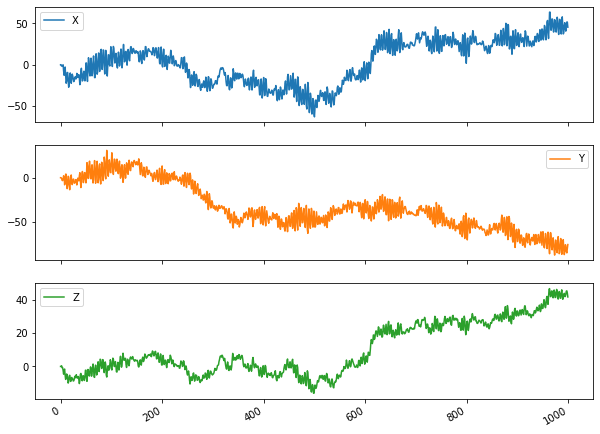

In [27]:
seriesXYZ.plot(subplots=True, figsize=(10,8))
plt.show()

**Create a VAR model**

In [30]:
model2 = VAR(seriesXYZ)

**Determine optimum lag order (p) by lag order selection**

In [31]:
lag_order = model2.select_order(15)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        15.65       15.66   6.259e+06       15.66
1        3.532       3.591       34.18       3.554
2     0.02254*     0.1268*      1.023*    0.06221*
3      0.03348      0.1825       1.034     0.09016
4      0.04409      0.2378       1.045      0.1178
5      0.05314      0.2916       1.055      0.1438
6      0.06478      0.3479       1.067      0.1725
7      0.07594      0.4038       1.079      0.2006
8      0.09108      0.4636       1.095      0.2328
9       0.1015      0.5187       1.107      0.2602
10      0.1017      0.5637       1.107      0.2774
11      0.1120      0.6186       1.119      0.3047
12      0.1233      0.6747       1.131      0.3330
13      0.1307      0.7268       1.140      0.3575
14      0.1401      0.7809       1.151      0.3838
15      0.1414      0.8268       1.152      0.4021
-------------------------------

**Model fit at optimum lag order and get results**

In [32]:
results = model2.fit(2)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 05, May, 2022
Time:                     00:27:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.143403
Nobs:                     998.000    HQIC:                 0.0794136
Log likelihood:          -4247.35    FPE:                    1.04099
AIC:                    0.0401762    Det(Omega_mle):         1.01939
--------------------------------------------------------------------
Results for equation X
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.068742         0.053248           -1.291           0.197
L1.X          0.703151         0.008206           85.692           0.000
L1.Y          0.224385         0.029645            7.569           0.000
L1.Z          2.023227 

**Use results to find roots**

In [38]:
nroots = 3*2  # K*p (K is number of features = 3, p is lag order = 2)
print('Roots =')
for i in range(0, nroots):
    print(VARResults.roots(results)[i])
print()
print('Moduli =')
for i in range(0, nroots):
    print(np.absolute(VARResults.roots(results)[i]))

Roots =
(21.584291192040038-0j)
(2.2958277878268047-0j)
(0.28859758189183676+0.9886262824620397j)
(0.28859758189183676-0.9886262824620397j)
(1.0042965693899355-0j)
(0.9993052689463221-0j)

Moduli =
21.584291192040038
2.2958277878268047
1.0298885816672247
1.0298885816672247
1.0042965693899355
0.9993052689463221


**Is the model stationary?**

No, the model is not stationary, since some roots have moduli as 1.

**Is the model cointegrated?**

The model is cointegrated since some of the roots are unity and other are greater than 1 in absolute value.

**If Cointegrated:**

**Perform a Johansen cointegration test. What is the cointegration rank?**

In [44]:
rank_test = select_coint_rank(seriesXYZ, -1, 2, method="trace", signif=0.05)
print(rank_test)
print("Rank = ", rank_test.rank)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          452.3          24.28
  1   3          5.069          12.32
-------------------------------------
Rank =  1


**Create a VECM model (with no deterministic terms) and fit**

In [56]:
lag_order = select_order(data=seriesXYZ, maxlags=10)

model = VECM(seriesXYZ, deterministic='nc', coint_rank=rank_test.rank, k_ar_diff=lag_order.aic)
vecm_res = model.fit()
print(vecm_res.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation X
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.X           0.5314      0.027     19.648      0.000       0.478       0.584
L1.Y          -0.1870      0.017    -10.934      0.000      -0.221      -0.153
L1.Z           0.3653      0.077      4.770      0.000       0.215       0.515
Det. terms outside the coint. relation & lagged endog. parameters for equation Y
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.X           0.3405      0.026     12.921      0.000       0.289       0.392
L1.Y           0.2365      0.017     14.189      0.000       0.204       0.269
L1.Z          -0.4886      0.075     -6.549      0.000      -0.635      -0.342
Det. terms outside the coint. relation & lagged 

**What are $\alpha$ and $\beta$ matrices?**

In [53]:
print('Alpha:')
print(vecm_res.alpha)
print('Beta:')
print(vecm_res.beta)

Alpha:
[[-0.8702748 ]
 [ 0.56087864]
 [-0.2055741 ]]
Beta:
[[ 1.        ]
 [-0.49959688]
 [-2.00084199]]


**Whether VAR or VECM model, perform a dynamic forecast 10 steps forward and plot**

forecast:
[[ 39.96913017 -75.88444219  42.34106421]
 [ 43.17137417 -81.90848392  43.9478726 ]
 [ 49.78342112 -85.24401553  44.02248256]
 [ 50.41572982 -81.33746166  42.5153868 ]
 [ 44.5149608  -75.99726314  41.62313141]
 [ 40.70282345 -76.76418593  42.56608318]
 [ 44.22084518 -82.23903466  43.92954698]
 [ 49.76477953 -84.50277993  43.78205946]
 [ 49.46387575 -80.54730727  42.40878379]
 [ 44.04298534 -76.23540929  41.79750588]]
lower:
[[ 37.98332635 -77.82343731  40.3856141 ]
 [ 38.49993735 -86.42046838  40.57046109]
 [ 41.40110611 -91.48969488  39.88523893]
 [ 40.24327901 -88.08262251  38.12189413]
 [ 33.99279924 -83.52178848  36.99630068]
 [ 29.85770139 -84.89462332  37.42047978]
 [ 32.33823458 -91.3429469   38.0897628 ]
 [ 36.03917737 -94.40682022  37.51075273]
 [ 34.735991   -90.78816225  35.9594979 ]
 [ 29.06734966 -86.97337719  35.15663543]]
upper:
[[ 41.954934   -73.94544706  44.29651432]
 [ 47.842811   -77.39649946  47.32528411]
 [ 58.16573613 -78.99833618  48.15972619]
 [ 60.58

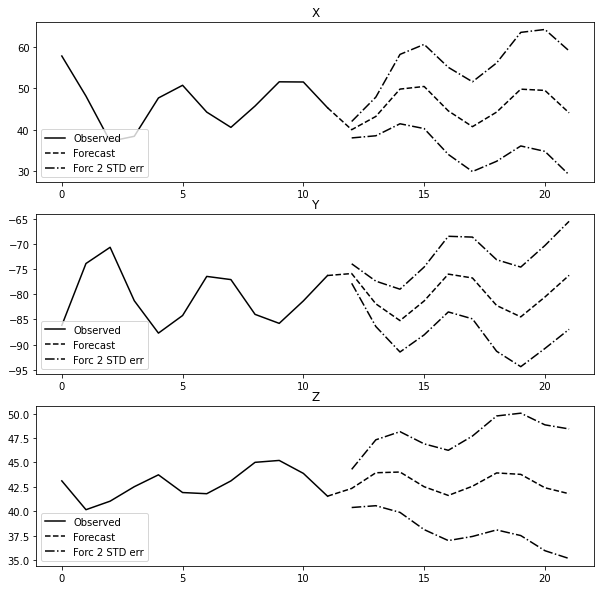

In [49]:
for text, values in zip(("forecast", "lower", "upper"), vecm_res.predict(steps=10, alpha=0.05)):
    print(text+":", values, sep="\n")

#vecm_res.plot_forecast(steps=10, plot_conf_int=False)
vecm_res.plot_forecast(steps=10, n_last_obs=12)
plt.show()
